In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from copy import deepcopy

## MRM and CRR resonance definition

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(1e3+1), centroid_die_variation_bool=True, laser_distribution_uniform=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 0

bins = 101

## Plotting MRM and CRR resonances

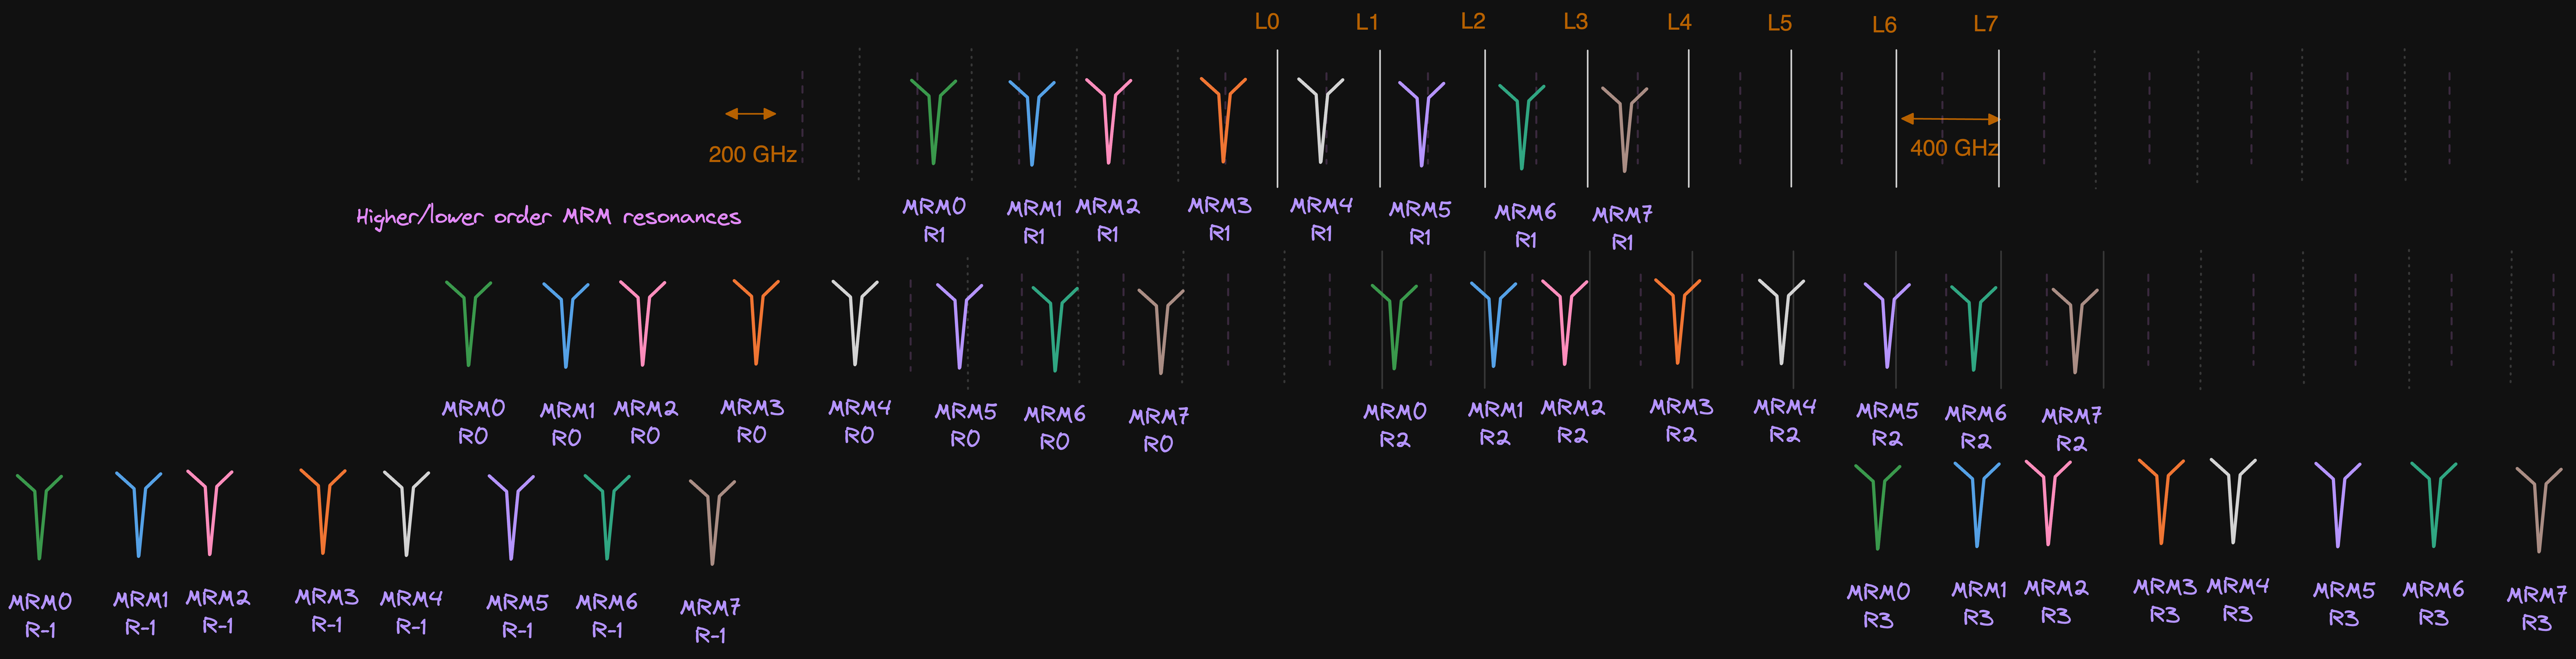

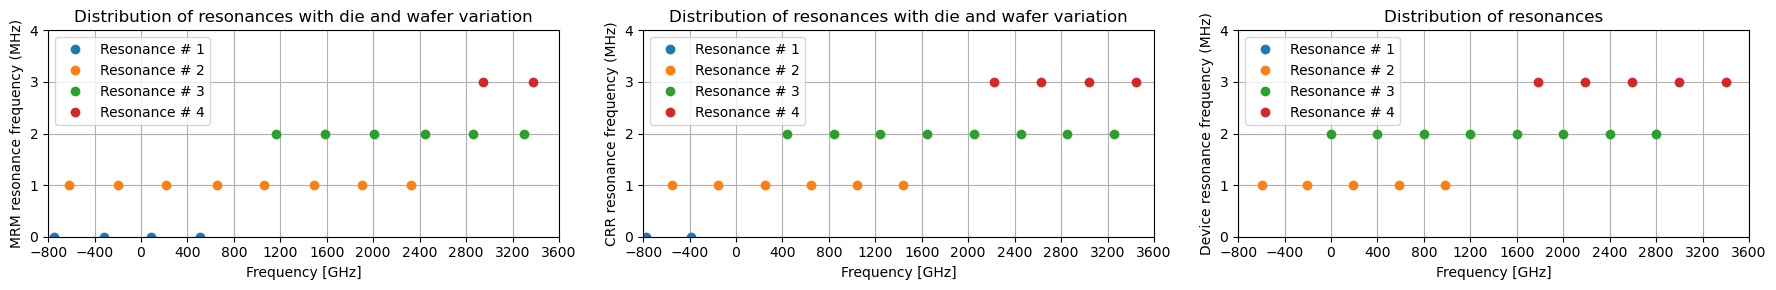

In [3]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Sequential Assignment of MRM

In [4]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, mrm_resonances_die_wafer_variation.shape[2]))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]
  if debug:
    print("\n")
    print("Iteration number", iter_no)
  device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
  heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
    
  optimized_heat = deepcopy(heat_assigned)
  mrm_lock_data[:, 0, iter_no] = device_dict["device_assigned"]
  mrm_lock_data[:, 1, iter_no] = device_dict["laser_assigned"]
  mrm_lock_data[:, 2, iter_no] = heat_assigned
  mrm_lock_data[:, 3, iter_no] = heat_applied
  mrm_lock_data[:, 4, iter_no] = device_dict["resonance_assigned"]
  mrm_lock_data[:, 5, iter_no] = device_dict["heat_cycling"]
  mrm_lock_data[:, 6, iter_no] = device_dict["cool_cycling"]
  mrm_assigned = mrm_lock_data[:, 0, iter_no]
  if mrm_assigned[0] < 7:
    mrm_sequence = deepcopy(mrm_assigned)
    for idx in np.linspace(mrm_assigned[0], 0, int( mrm_assigned[0])+1, dtype=int):
      mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
    for idx in np.linspace(7, mrm_assigned[0]+1, 7 - int(mrm_assigned[0]), dtype=int):
      mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
  else:
    mrm_sequence = deepcopy(mrm_assigned)
    
  for idx, val in enumerate(mrm_sequence):
    if val < 0:
      mrm_sequence[idx] = val + 7 + 1
  mrm_sequential_assigned.append(mrm_sequence)
  
  if np.min(np.diff(mrm_sequence)) == -1 or np.max(np.diff(mrm_sequence)) == 7:
    mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths", len(mrm_sequential_success_metric)/mrm_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 1001/1001 [00:00<00:00, 5752.48it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_18900/3043388300.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


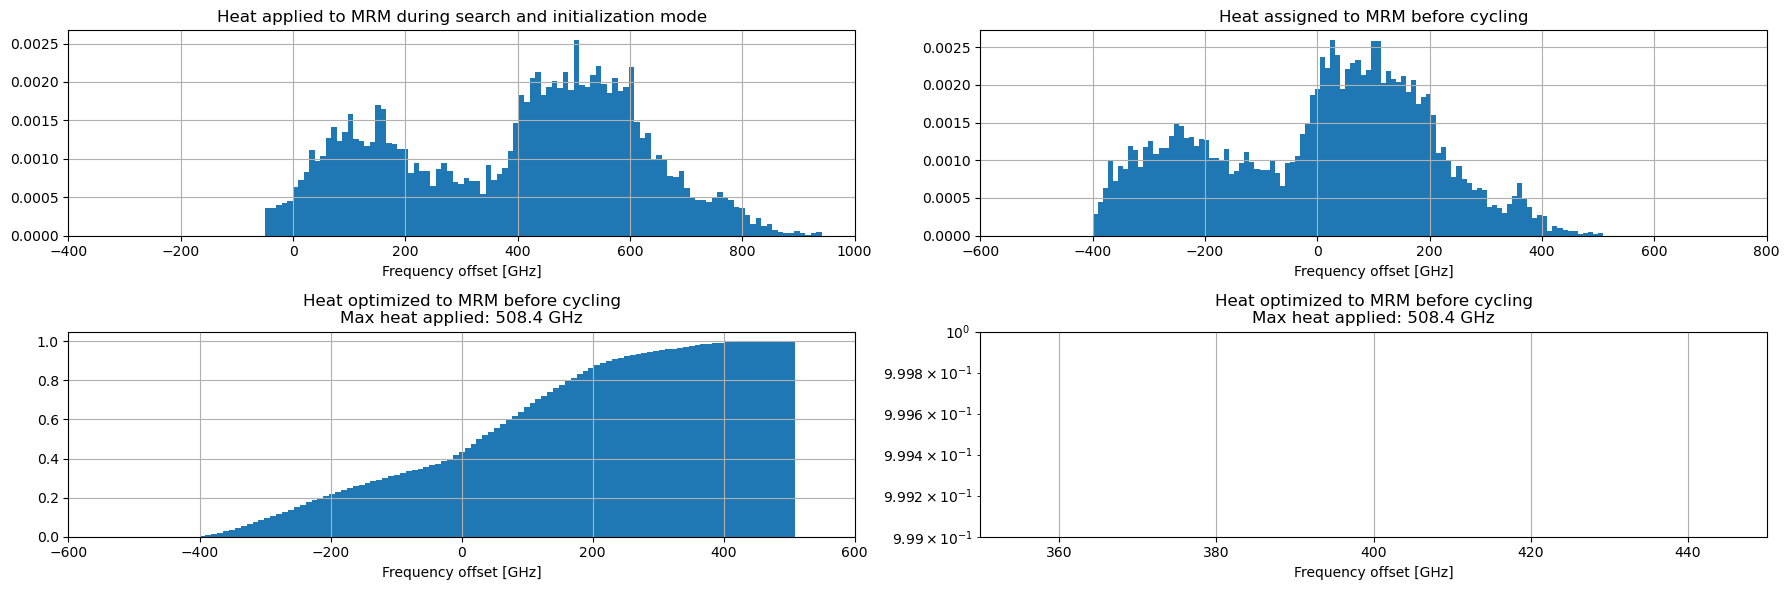

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.hist(mrm_lock_data[:, 3, :].flatten(), density=True, bins=bins)
plt.xlim([-400, 1000])
plt.grid()
plt.title("Heat applied to MRM during search and initialization mode")
plt.xlabel("Frequency offset [GHz]")
plt.subplot(222)
plt.hist(mrm_lock_data[:, 2, :].flatten(), density=True,  bins=bins)
plt.xlim([-600, 800])
plt.title("Heat assigned to MRM before cycling")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.subplot(223)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.xlim([-600, 600])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.subplot(224)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.yscale("log")
plt.ylim(0.999, 1.0)
plt.xlim([350, 450])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  if np.min(mrm_lock_data[:, 2, iter_no]) > 000:
    print("Iteration number", iter_no)
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    break

Iteration number 14
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [5. 4. 3. 2. 1. 0. 7. 6.]
Heat assigned: [112.68606278 167.12663611 212.48725594 257.50335345 289.87022575
 355.82184249  31.84581053  86.05804843]
Heat applied: [112.68606278 567.12663611 612.48725594 657.50335345 689.87022575
 755.82184249 803.84581053 486.05804843]
Resonance assigned: [2. 2. 2. 2. 2. 2. 4. 4.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


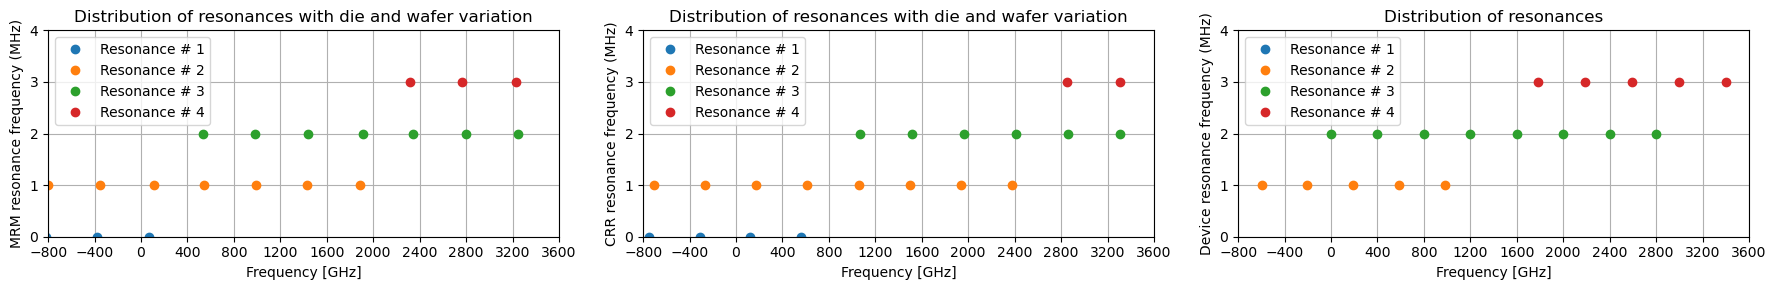

In [7]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

In [8]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  if np.min(mrm_lock_data[:, 2, iter_no]) < -300:
    print("Iteration number", iter_no)
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    break

Iteration number 9
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [0. 7. 6. 5. 4. 3. 2. 1.]
Heat assigned: [   6.54627353 -391.07225048 -364.40998796 -330.44602697 -294.08354308
 -247.34442182 -210.82585918 -176.36137434]
Heat applied: [  6.54627353 440.92774952  35.59001204  69.55397303 105.91645692
 152.65557818 189.17414082 223.63862566]
Resonance assigned: [1. 3. 3. 3. 3. 3. 3. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


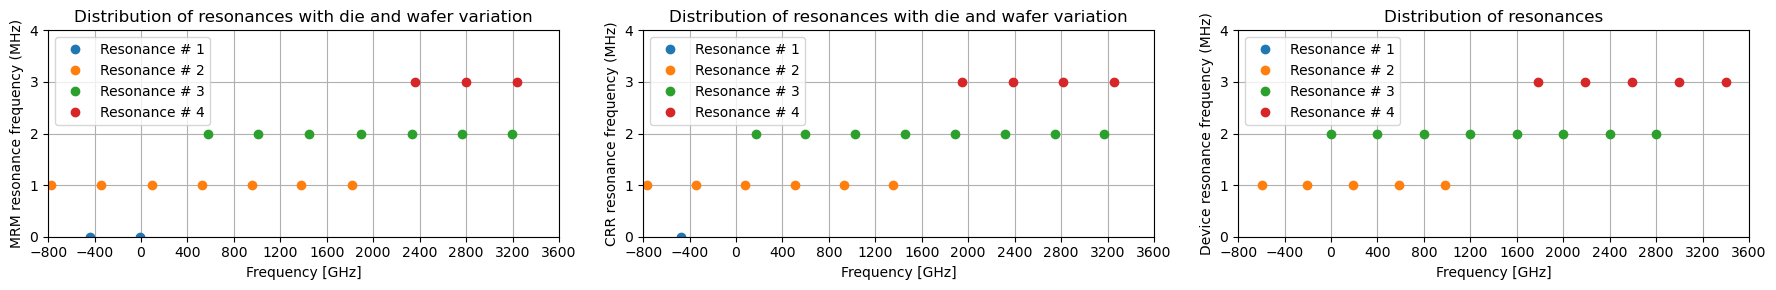

In [9]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## MRM and CRR cycling

In [10]:
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 6, crr_resonances_die_wafer_variation.shape[2]))
crr_lock_success_metric = []
iter_satisfaction = []

crr_laser_assigned = []
crr_sequential_assigned = []

no_mrm_cycling_steps = 3
no_crr_cycling_steps = 7
          
for iter_no in tqdm(range(crr_resonances_die_wafer_variation.shape[2])):
# for iter_no in tqdm(range(4)):
  crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

  mrm_heat_cycling = mrm_lock_data[0, 5, iter_no]

  mrm_assigned = mrm_lock_data[:, 0, iter_no]
  mrm_laser_assigned =  mrm_lock_data[:, 1, iter_no]
  mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]

  if debug:
    print("\n")
    print("Iteration number", iter_no)
    
  cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
  if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
    crr_lock_post_cycling_data[:, 0, iter_no] = cycled_crr_dict["crr_assigned"]
    crr_lock_post_cycling_data[:, 1, iter_no] = cycled_crr_dict["crr_laser_assigned"]
    crr_lock_post_cycling_data[:, 2, iter_no] = cycled_crr_dict["crr_heat_assigned"]
    crr_lock_post_cycling_data[:, 3, iter_no] = cycled_crr_dict["crr_resonance_assigned"]
    crr_lock_post_cycling_data[:, 4, iter_no] = cycled_crr_dict["crr_cycling_assigned"]
    crr_lock_post_cycling_data[:, 5, iter_no] = cycled_crr_dict["mrm_cycling_assigned"]
    crr_lock_success_metric.append(iter_no)
  # else:
  #   break

print("Successful locking of CRRs to MRMs", len(crr_lock_success_metric)/crr_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 1001/1001 [00:01<00:00, 854.71it/s]

Successful locking of CRRs to MRMs 100.0 %


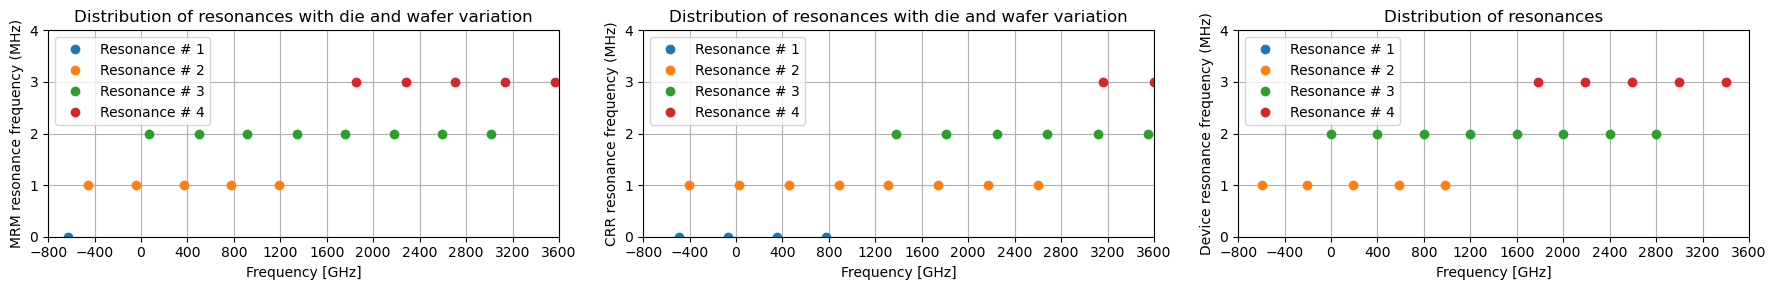

In [11]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

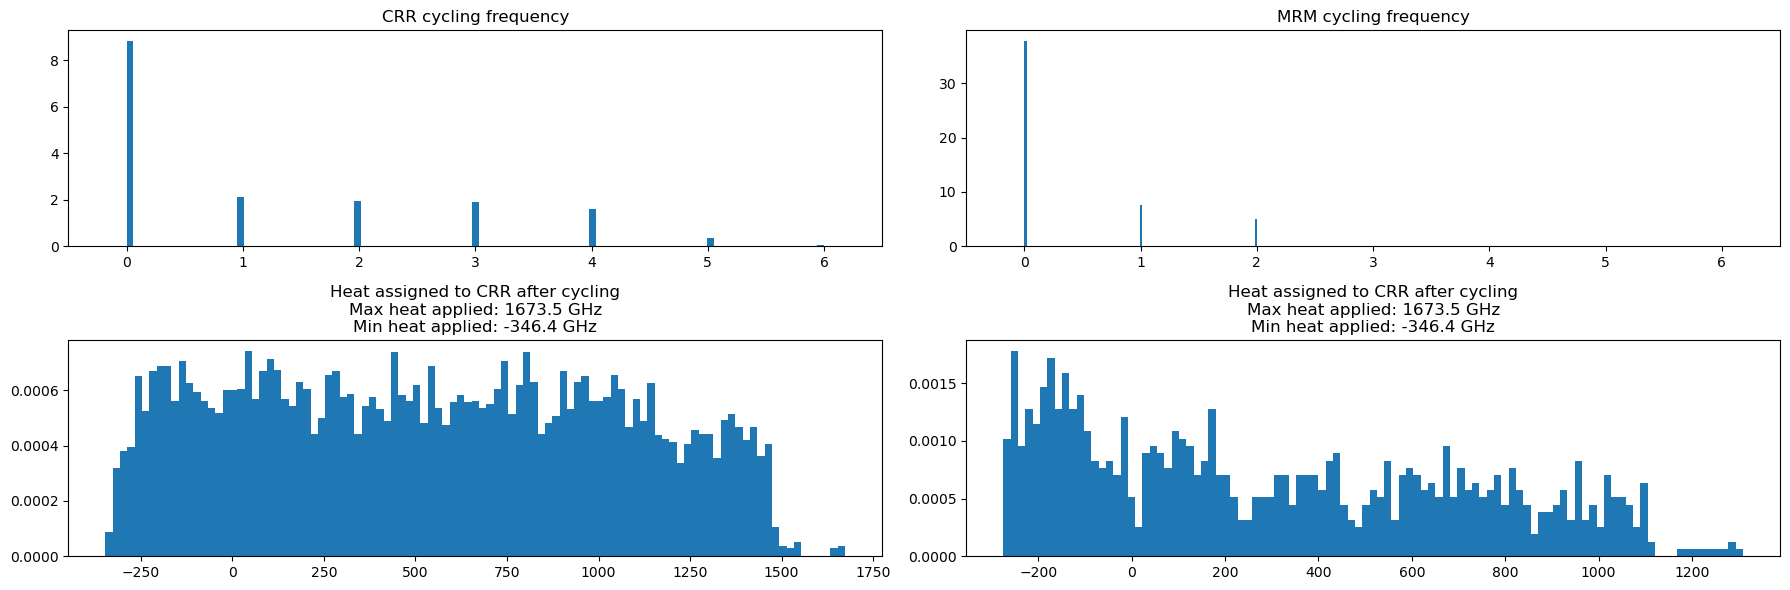

In [12]:
fig = plt.figure(figsize=(18,6))
plt.subplot(221)
plt.hist(crr_lock_post_cycling_data[:, 4, :].flatten(), density=True, bins=bins)
plt.title("CRR cycling frequency")
plt.xlim([-0.5, 6.5])
plt.subplot(222)
plt.hist(crr_lock_post_cycling_data[:, 5, :].flatten(), density=True, bins=bins)
plt.title("MRM cycling frequency")
plt.xlim([-0.5, 6.5])
plt.subplot(223)
plt.hist(crr_lock_post_cycling_data[:, 2, :].flatten(), density=True, bins=bins)
plt.title("Heat assigned to CRR after cycling\n"+f"Max heat applied: {np.max(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz\n"+f"Min heat applied: {np.min(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz")
plt.subplot(224)
plt.hist(crr_lock_post_cycling_data[0, 2, :].flatten(), density=True, bins=bins)
plt.title("Heat assigned to CRR after cycling\n"+f"Max heat applied: {np.max(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz\n"+f"Min heat applied: {np.min(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz")
plt.tight_layout()
plt.show()